In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, EfficientNetB0, ResNet50, MobileNetV2
from sklearn.metrics import confusion_matrix, classification_report
import time
import csv

In [43]:
# Directories
train_path = 'data/train'
valid_path = 'data/valid'
test_path = 'data/test'
os.makedirs("results", exist_ok=True)

In [3]:
# Image data generators
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
train_batches = datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=32, class_mode='categorical')
valid_batches = datagen.flow_from_directory(valid_path, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)
test_batches = datagen.flow_from_directory(test_path, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)

Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [4]:
# Custom model builders
def build_arcnet(base_model):
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    output = Dense(4, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=output)

In [5]:
def build_arcnet_mobilenet():
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    return build_arcnet(base)

In [6]:
def build_arcnet_vgg16():
    base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    return build_arcnet(base)

In [7]:
def build_rescuenet():
    input_tensor = Input(shape=(224, 224, 3))
    x = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')(input_tensor)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(4, activation='softmax')(x)
    return Model(inputs=input_tensor, outputs=output)

In [8]:
# Model factory
def create_model(name):
    if name == 'VGG16':
        return build_arcnet(VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
    elif name == 'EfficientNet':
        return build_arcnet(EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
    elif name == 'ResNet50':
        return build_arcnet(ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
    elif name == 'MobileNet':
        return build_arcnet(MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
    elif name == 'ARCNet-MobileNet':
        return build_arcnet_mobilenet()
    elif name == 'ARCNet-VGG16':
        return build_arcnet_vgg16()
    elif name == 'RescueNet':
        return build_rescuenet()
    else:
        raise ValueError(f"Unknown model: {name}")

In [24]:
# Evaluation
results_summary = {}
training_times = {}

def evaluate_model(name, model, test_batches):
    loss, accuracy = model.evaluate(test_batches, verbose=0)
    y_true = test_batches.classes
    y_pred = np.argmax(model.predict(test_batches), axis=-1)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=test_batches.class_indices.keys()))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=test_batches.class_indices.keys(), yticklabels=test_batches.class_indices.keys(), cmap="Blues")
    plt.title(f'{name} Confusion Matrix')
    plt.savefig(f"results/{name}_confusion_matrix.png")
    plt.close()

    results_summary[name] = accuracy

In [45]:
# Plot training curves
def plot_training_curves(name, history):
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{name} Training Accuracy')
    plt.legend()
    plt.savefig(f"results/{name}_training_accuracy.png")
    plt.close()

In [46]:
def plot_loss_curves(name, history):
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{name} Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"results/{name}_training_loss.png")
    plt.close()

In [47]:
# Display prediction
def display_prediction(image_path, model, class_indices):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    class_names = {v: k for k, v in class_indices.items()}
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {class_names[predicted_class]}', color='black')
    plt.show()

In [13]:
# Train and evaluate
model_names = ['VGG16', 'EfficientNet', 'ResNet50', 'MobileNet', 'ARCNet-MobileNet', 'RescueNet', 'ARCNet-VGG16']

for name in model_names:
    print(f"\n--- Training {name} ---")
    model = create_model(name)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    start_time = time.time()
    history = model.fit(train_batches, validation_data=valid_batches, epochs=10, verbose=2)
    training_time = (time.time() - start_time) / 60  
    print(f"Training Time for {name}: {training_time:.2f} minutes")

    # Save the model and training time
    model.save(f'results/{name}.keras')
    training_times[name] = training_time

    print(f"\n--- Evaluating {name} ---")
    evaluate_model(name, model, test_batches)
    plot_training_curves(name, history)


--- Training VGG16 ---
Epoch 1/10
50/50 - 288s - loss: 1.2399 - accuracy: 0.8062 - val_loss: 0.2717 - val_accuracy: 0.9275 - 288s/epoch - 6s/step
Epoch 2/10
50/50 - 285s - loss: 0.2758 - accuracy: 0.9262 - val_loss: 0.1928 - val_accuracy: 0.9475 - 285s/epoch - 6s/step
Epoch 3/10
50/50 - 296s - loss: 0.1434 - accuracy: 0.9538 - val_loss: 0.2187 - val_accuracy: 0.9375 - 296s/epoch - 6s/step
Epoch 4/10
50/50 - 283s - loss: 0.1209 - accuracy: 0.9656 - val_loss: 0.2468 - val_accuracy: 0.9425 - 283s/epoch - 6s/step
Epoch 5/10
50/50 - 284s - loss: 0.0725 - accuracy: 0.9731 - val_loss: 0.1973 - val_accuracy: 0.9400 - 284s/epoch - 6s/step
Epoch 6/10
50/50 - 284s - loss: 0.0639 - accuracy: 0.9750 - val_loss: 0.2003 - val_accuracy: 0.9450 - 284s/epoch - 6s/step
Epoch 7/10
50/50 - 283s - loss: 0.0611 - accuracy: 0.9831 - val_loss: 0.2012 - val_accuracy: 0.9475 - 283s/epoch - 6s/step
Epoch 8/10
50/50 - 282s - loss: 0.0473 - accuracy: 0.9862 - val_loss: 0.1991 - val_accuracy: 0.9475 - 282s/epoch - 

Epoch 8/10
50/50 - 48s - loss: 0.2575 - accuracy: 0.9162 - val_loss: 0.6121 - val_accuracy: 0.7925 - 48s/epoch - 968ms/step
Epoch 9/10
50/50 - 49s - loss: 0.2290 - accuracy: 0.9250 - val_loss: 0.5546 - val_accuracy: 0.8200 - 49s/epoch - 971ms/step
Epoch 10/10
50/50 - 49s - loss: 0.2175 - accuracy: 0.9219 - val_loss: 0.5489 - val_accuracy: 0.8250 - 49s/epoch - 973ms/step
Training Time for ARCNet-MobileNet: 8.27 minutes

--- Evaluating ARCNet-MobileNet ---
13/13 [==============================] - 10s 678ms/step

Classification Report:
              precision    recall  f1-score   support

     cyclone       0.89      0.77      0.82       100
  earthquake       0.67      0.92      0.78       100
       flood       0.76      0.69      0.72       100
    wildfire       0.94      0.80      0.86       100

    accuracy                           0.80       400
   macro avg       0.81      0.79      0.80       400
weighted avg       0.81      0.80      0.80       400


--- Training RescueNet --

In [48]:
# Save the summary data to a CSV file
with open('results/training_summary.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Model', 'Accuracy', 'Training Time (min)'])
    for model_name in model_names:
        writer.writerow([model_name, results_summary.get(model_name, 'N/A'), training_times.get(model_name, 'N/A')])

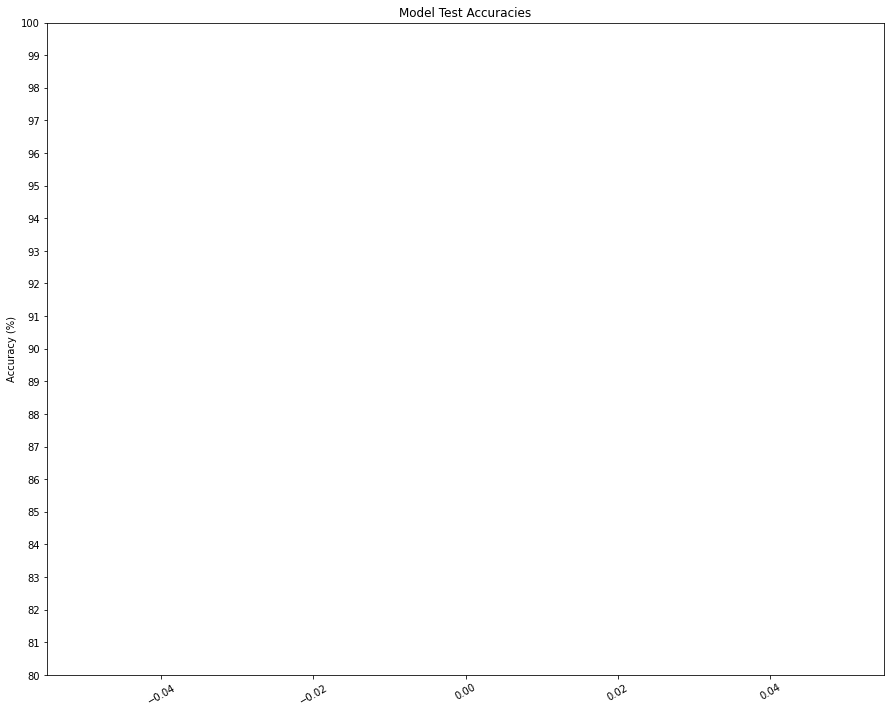

In [49]:
# Accuracy chart
plt.figure(figsize=(15, 12))
plt.bar(results_summary.keys(), [acc * 100 for acc in results_summary.values()], color='skyblue')
plt.title("Model Test Accuracies")
plt.ylabel("Accuracy (%)")
plt.ylim(80, 100)  # Set y-axis to start from 50% to 100%
plt.xticks(rotation=30)
plt.yticks(np.arange(80, 101, 1))
plt.show()

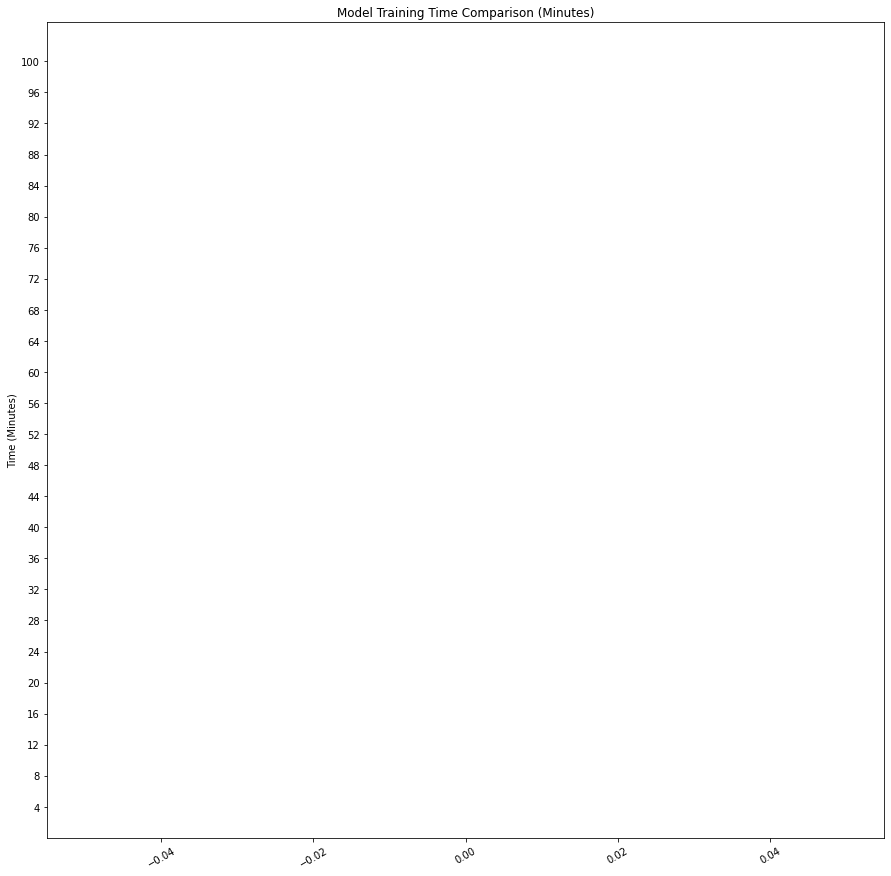

In [30]:
# Training time chart
plt.figure(figsize=(15, 15))
plt.bar(training_times.keys(), training_times.values(), color='lightgreen')
plt.title("Model Training Time Comparison (Minutes)")
plt.ylabel("Time (Minutes)")
plt.ylim(0, 105)  # Set y-axis to start from 10 minutes to 120 minutes
plt.xticks(rotation=30)
plt.yticks(np.arange(4, 102, 4))
plt.show()

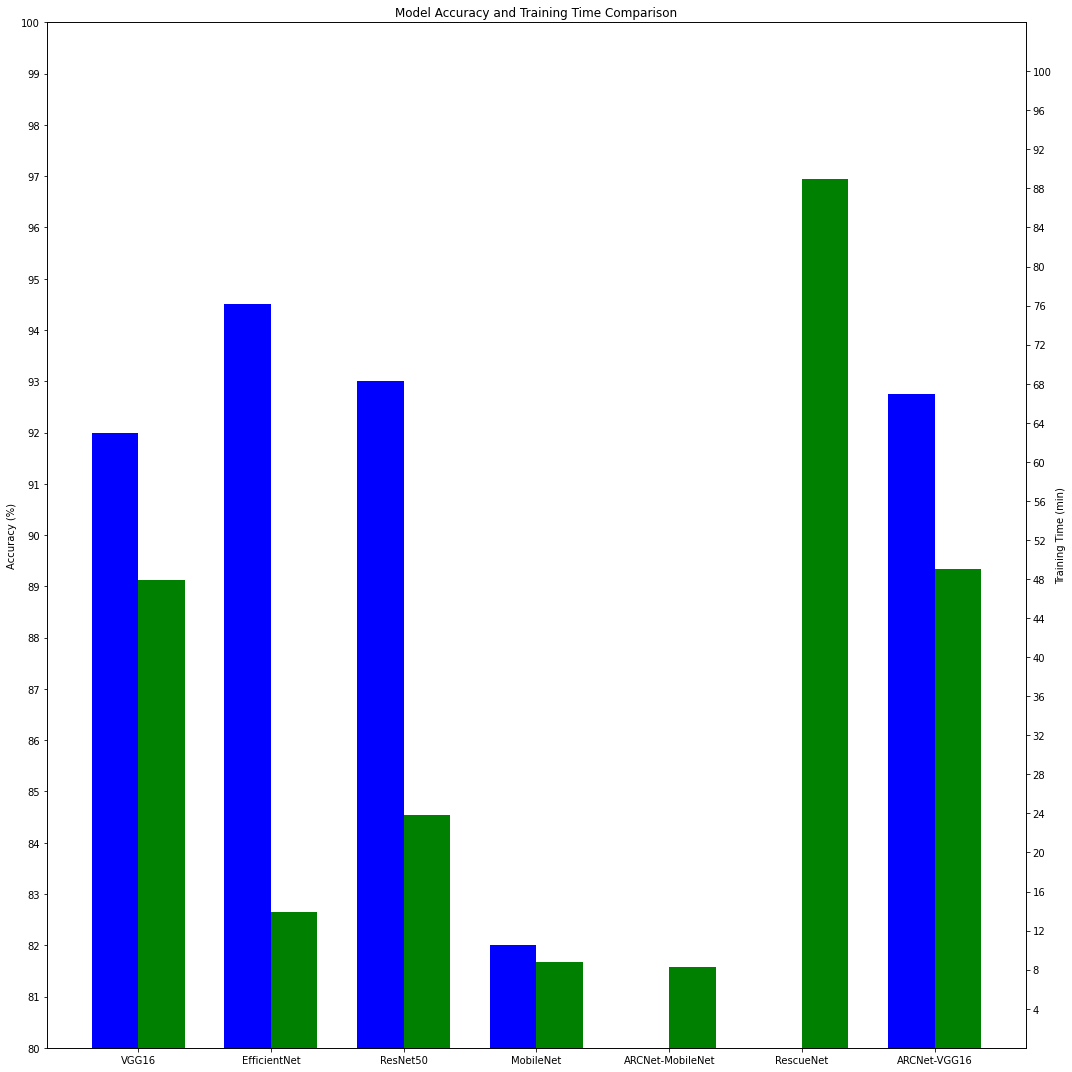

In [17]:
model_names = list(results_summary.keys())
accuracies = [results_summary[name] * 100 for name in model_names]
training_minutes = [training_times[name] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

fig, ax1 = plt.subplots(figsize=(15, 15))

# Plot Accuracy
ax1.bar(x - width/2, accuracies, width, label='Accuracy (%)', color='blue')
ax1.set_ylabel('Accuracy (%)', color='black')
ax1.set_ylim(80, 100)
ax1.set_yticks(np.arange(80, 101, 1))
ax1.tick_params(axis='y', labelcolor='black')

# Plot Training Time
ax2 = ax1.twinx()
ax2.bar(x + width/2, training_minutes, width, label='Training Time (min)', color='green')
ax2.set_ylabel('Training Time (min)', color='black')
ax2.set_ylim(0, 105)
ax2.set_yticks(np.arange(4, 102, 4))
ax2.tick_params(axis='y', labelcolor='black')

# X-axis
plt.xticks(x, model_names, rotation=30)
plt.title('Model Accuracy and Training Time Comparison')
fig.tight_layout()

# Save and show
plt.show()

In [59]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


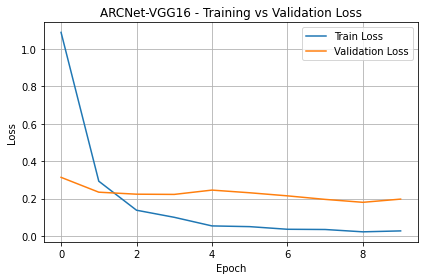

In [64]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ARCNet-VGG16 - Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('results/ARCNet-VGG16_loss_curve.png', dpi=300)
plt.show()

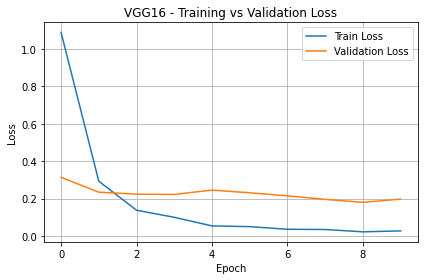

In [65]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('VGG16 - Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('results/VGG16_loss_curve.png', dpi=300)
plt.show()

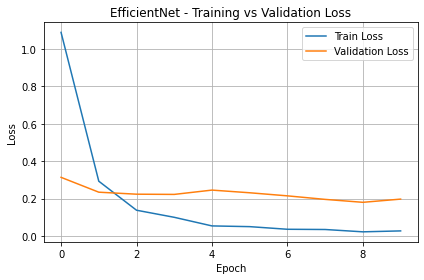

In [66]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('EfficientNet - Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('results/EfficientNet_loss_curve.png', dpi=300)
plt.show()

In [72]:
history_vgg16 = vgg16_model.fit(...)
history_efficientnet = efficientnet_model.fit(...)
history_arcvgg16 = arcvgg16_model.fit(...)

NameError: name 'vgg16_model' is not defined

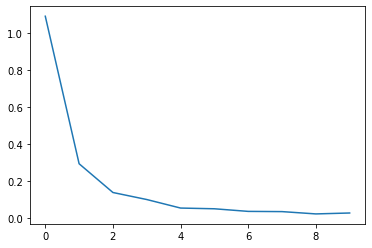

In [70]:
plt.plot(history.history['loss'])

In [73]:
loss_curves = {
    "VGG16": {
        "train_loss": [1.2399, 0.2758, 0.1434, 0.1209, 0.0725, 0.0639, 0.0611, 0.0473, 0.0308, 0.0276],
        "val_loss":   [0.2717, 0.1928, 0.2187, 0.2468, 0.1973, 0.2003, 0.2012, 0.1991, 0.1908, 0.1728],
    },
    "EfficientNetB0": {
        "train_loss": [0.1854, 0.0423, 0.0386, 0.0214, 0.0199, 0.0107, 0.0079, 0.0040, 0.0029, 0.0067],
        "val_loss":   [0.1038, 0.1248, 0.0974, 0.0998, 0.1230, 0.1323, 0.1407, 0.1378, 0.1289, 0.1512],
    },
    "ResNet50": {
        "train_loss": [0.3379, 0.0707, 0.0788, 0.0419, 0.0208, 0.0151, 0.0206, 0.0111, 0.0123, 0.0072],
        "val_loss":   [0.1144, 0.1033, 0.1234, 0.1201, 0.1081, 0.1222, 0.1226, 0.1096, 0.1126, 0.1171],
    },
    "MobileNet": {
        "train_loss": [0.7885, 0.4961, 0.4277, 0.3838, 0.3325, 0.3062, 0.2895, 0.2433, 0.2375, 0.1911],
        "val_loss":   [0.6700, 0.5778, 0.5732, 0.6139, 0.5044, 0.5825, 0.5292, 0.4950, 0.5068, 0.5165],
    },
    "ARCNet-MobileNet": {
        "train_loss": [0.8332, 0.4835, 0.4333, 0.3709, 0.3426, 0.2933, 0.3073, 0.2575, 0.2290, 0.2175],
        "val_loss":   [0.6618, 0.6229, 0.7099, 0.5274, 0.5240, 0.5291, 0.5482, 0.6121, 0.5546, 0.5489],
    },
    "RescueNet": {
        "train_loss": [0.6253, 0.5111, 0.3338, 0.5818, 0.8466, 0.4189, 0.2444, 0.1877, 0.1814, 0.2111],
        "val_loss":   [11786776.0, 1175437.6, 30.9451, 51280108.0, 43.5316, 4.0783, 1.0285, 0.8434, 1.0495, 2.0918],
    },
    "ARCNet-VGG16": {
        "train_loss": [1.0887, 0.2931, 0.1380, 0.1001, 0.0541, 0.0502, 0.0362, 0.0350, 0.0225, 0.0274],
        "val_loss":   [0.3138, 0.2344, 0.2237, 0.2225, 0.2456, 0.2313, 0.2148, 0.1959, 0.1803, 0.1974],
    },
}

In [74]:
for model_name, data in loss_curves.items():
    epochs = np.arange(1, len(data["train_loss"]) + 1)
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, data["train_loss"], 'o-', label='Train Loss')
    plt.plot(epochs, data["val_loss"], 's-', label='Validation Loss')
    plt.title(f'{model_name} - Training vs Validation Loss', fontsize=12)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(f'results/{model_name}_loss_curve.png', dpi=300)
    plt.close()

print("✅ All loss curves generated and saved in 'results/' folder.")

✅ All loss curves generated and saved in 'results/' folder.
